In [1]:
import os
import mne
import numpy as np
import pandas as pd

In [2]:
sub_path  ='X:\\4 e-Lab\\' # y:\\eLab
subj = 'EL011'
path_gen = os.path.join(sub_path+'\Patients\\' + subj)
if not os.path.exists(path_gen):
    path_gen = 'T:\\EL_experiment\\Patients\\' + subj
path_patient = path_gen + '\Data\EL_experiment'  # os.path.dirname(os.path.dirname(cwd))+'/Patients/'+subj
path_infos = os.path.join(path_gen, 'Electrodes')

In [3]:
lbls_BP = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='BP')
lbls_MP = pd.read_excel(os.path.join(path_infos, subj + "_labels.xlsx"), header=0, sheet_name='MP')

In [4]:
file_path = os.path.join(path_gen, 'Data_raw', 'Seizure')
files  = os.listdir(file_path)

In [23]:
file_ix = 0
file_path = os.path.join(file_path, files[file_ix])
# get MP indeces
ix_MP = np.where(lbls_MP.type=='SEEG')[0]
# get BP indeces
lbls_MP_clean = lbls_MP[lbls_MP.type=='SEEG'].reset_index(drop=True)
n_BP = len(lbls_BP[lbls_BP.type=='SEEG'])
ixP = np.zeros((n_BP,))
ixN = np.zeros((n_BP,))
for i in range(n_BP):
    ixP[i] = np.where(lbls_MP_clean.natus == lbls_BP.loc[lbls_BP.type=='SEEG','ChanP'].values[i])[0][0]
    ixN[i] = np.where(lbls_MP_clean.natus == lbls_BP.loc[lbls_BP.type=='SEEG','ChanN'].values[i])[0][0]
ixP = ixP.astype('int')
ixN = ixN.astype('int')

## Load MP Data

In [8]:
##Load MP
raw = mne.io.read_raw_edf(file_path, preload=True) # import_edf(os.path.join(file_path, file))
# Pick only the selected channels
raw.pick_channels([raw.ch_names[i] for i in ix_MP])
sfreq = raw.info['sfreq']
ch_names = [ ch['ch_name'] for ch in raw.info['chs'] ]

Extracting EDF parameters from X:\4 e-Lab\Patients\EL011\Data_raw\Seizure\EL011_SZ1_spontanous.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 759039  =      0.000 ...   741.249 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [ ]:
powerfs = np.arange(50, sfreq / 2, 50)
raw = raw.notch_filter(freqs=powerfs)

lfp_raw = raw.copy()
lfp_raw = lfp_raw.filter(l_freq=.5, h_freq=200)

## Load BP Data

In [39]:
raw.annotations[1]['onset']

160.950195

In [25]:
# Get the EEG data from the original raw object
eeg = raw.get_data()

# Calculate the bipolar EEG
eeg_bp = eeg[ixP] - eeg[ixN]

# Define the channel labels for the bipolar montage
labels_BP = lbls_BP.loc[lbls_BP.type=='SEEG', 'Clinic'].to_list()

# Create an info structure for the bipolar montage
info_bp = mne.create_info(
    ch_names=labels_BP,
    sfreq=raw.info['sfreq'],
    ch_types='eeg'
)

# Create a Raw object for the bipolar montage
raw_bp = mne.io.RawArray(eeg_bp, info_bp)

# Set annotations with orig_time set to None
annotations = mne.Annotations(onset=raw_bp.times[0], duration=0, description='Bipolar')
raw_bp.set_annotations(annotations)

# Now, raw_bp is a Raw object with bipolar montage EEG data and the same information as in raw

Creating RawArray with float64 data, n_channels=87, n_times=759040
    Range : 0 ... 759039 =      0.000 ...   741.249 secs
Ready.


<RawArray | 87 x 759040 (741.2 s), ~503.9 MB, data loaded>

In [28]:
powerfs = np.arange(50, sfreq / 2, 50)
raw_bp = raw_bp.notch_filter(freqs=powerfs)
raw_bp = raw_bp.filter(l_freq=.5, h_freq=200)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 6759 samples (6.601 s)



[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  87 out of  87 | elapsed:    1.6s finished


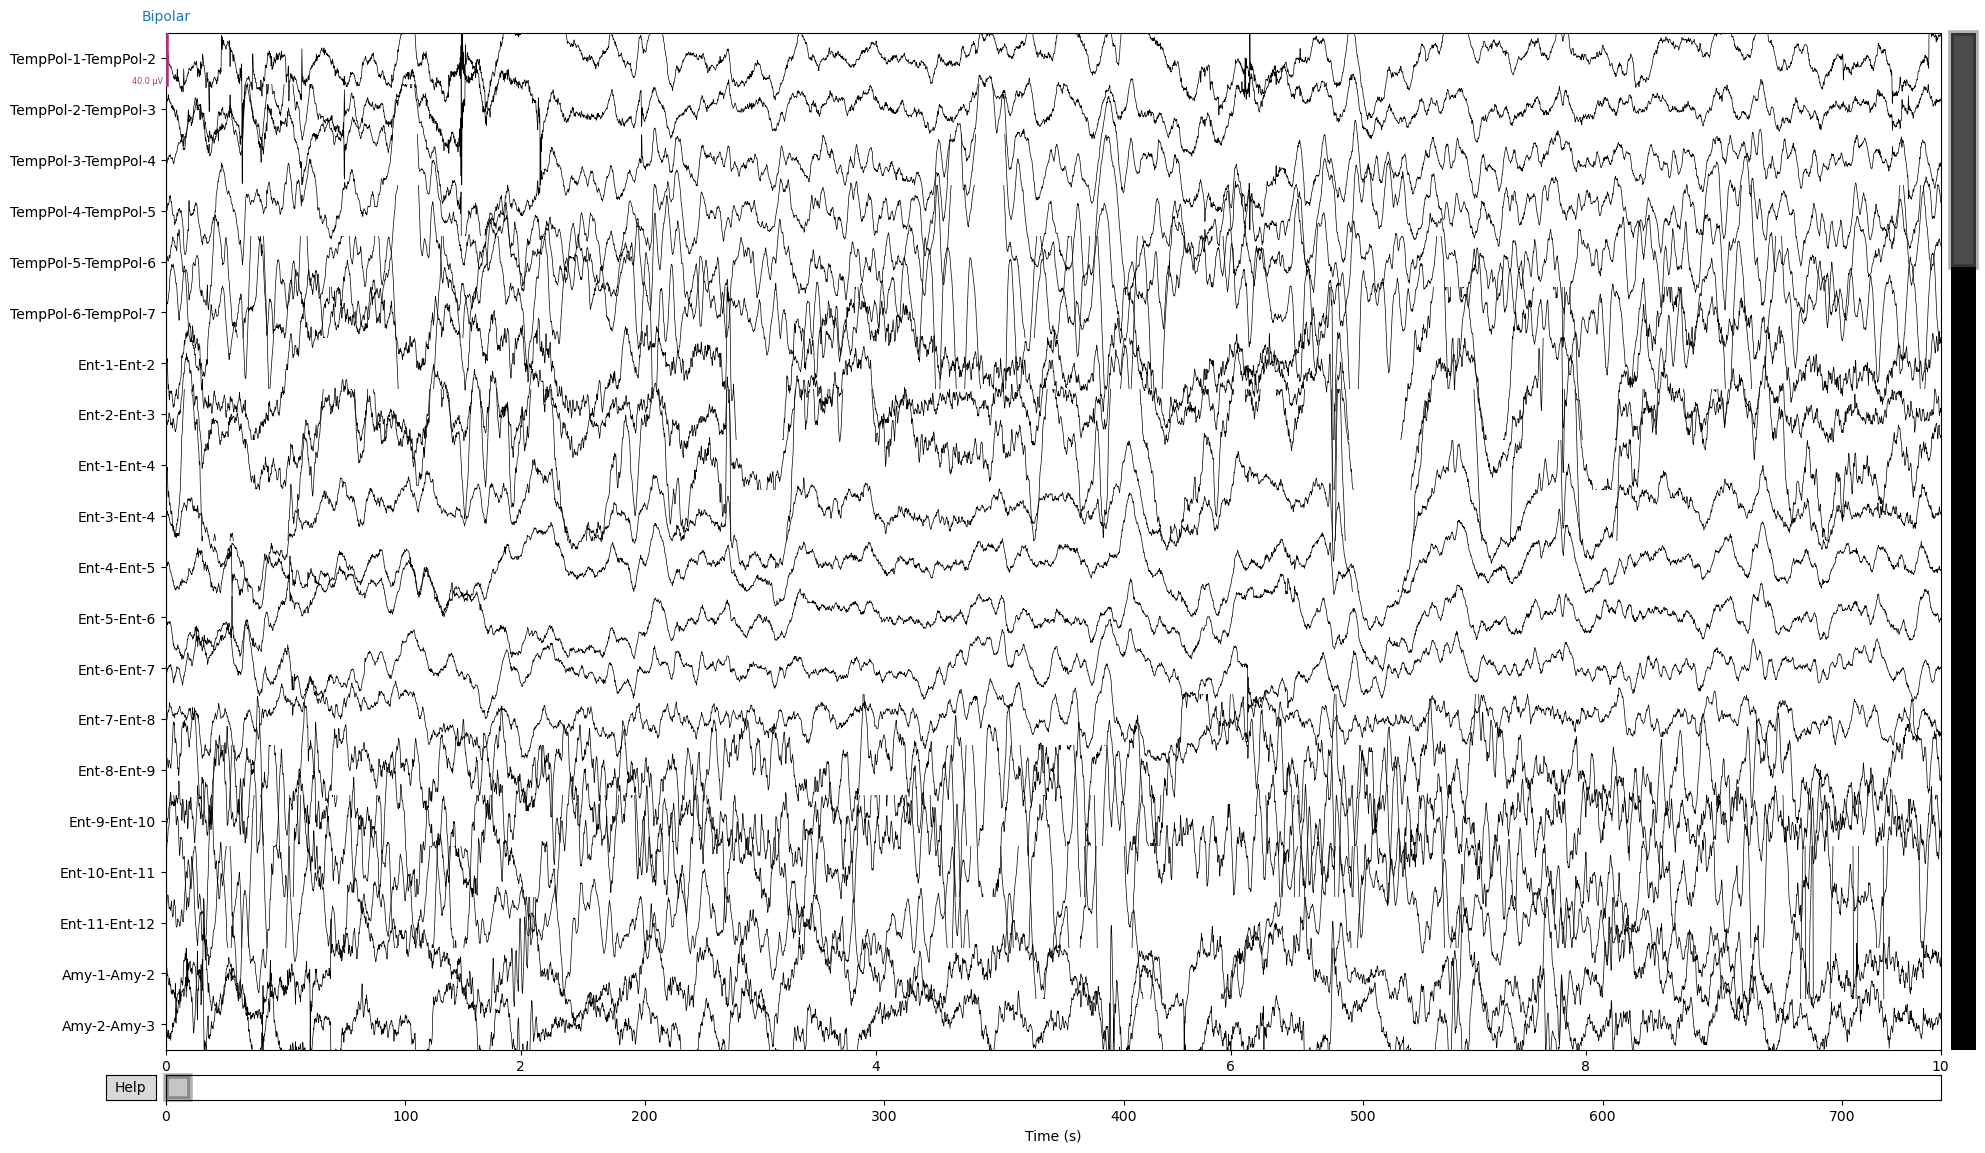

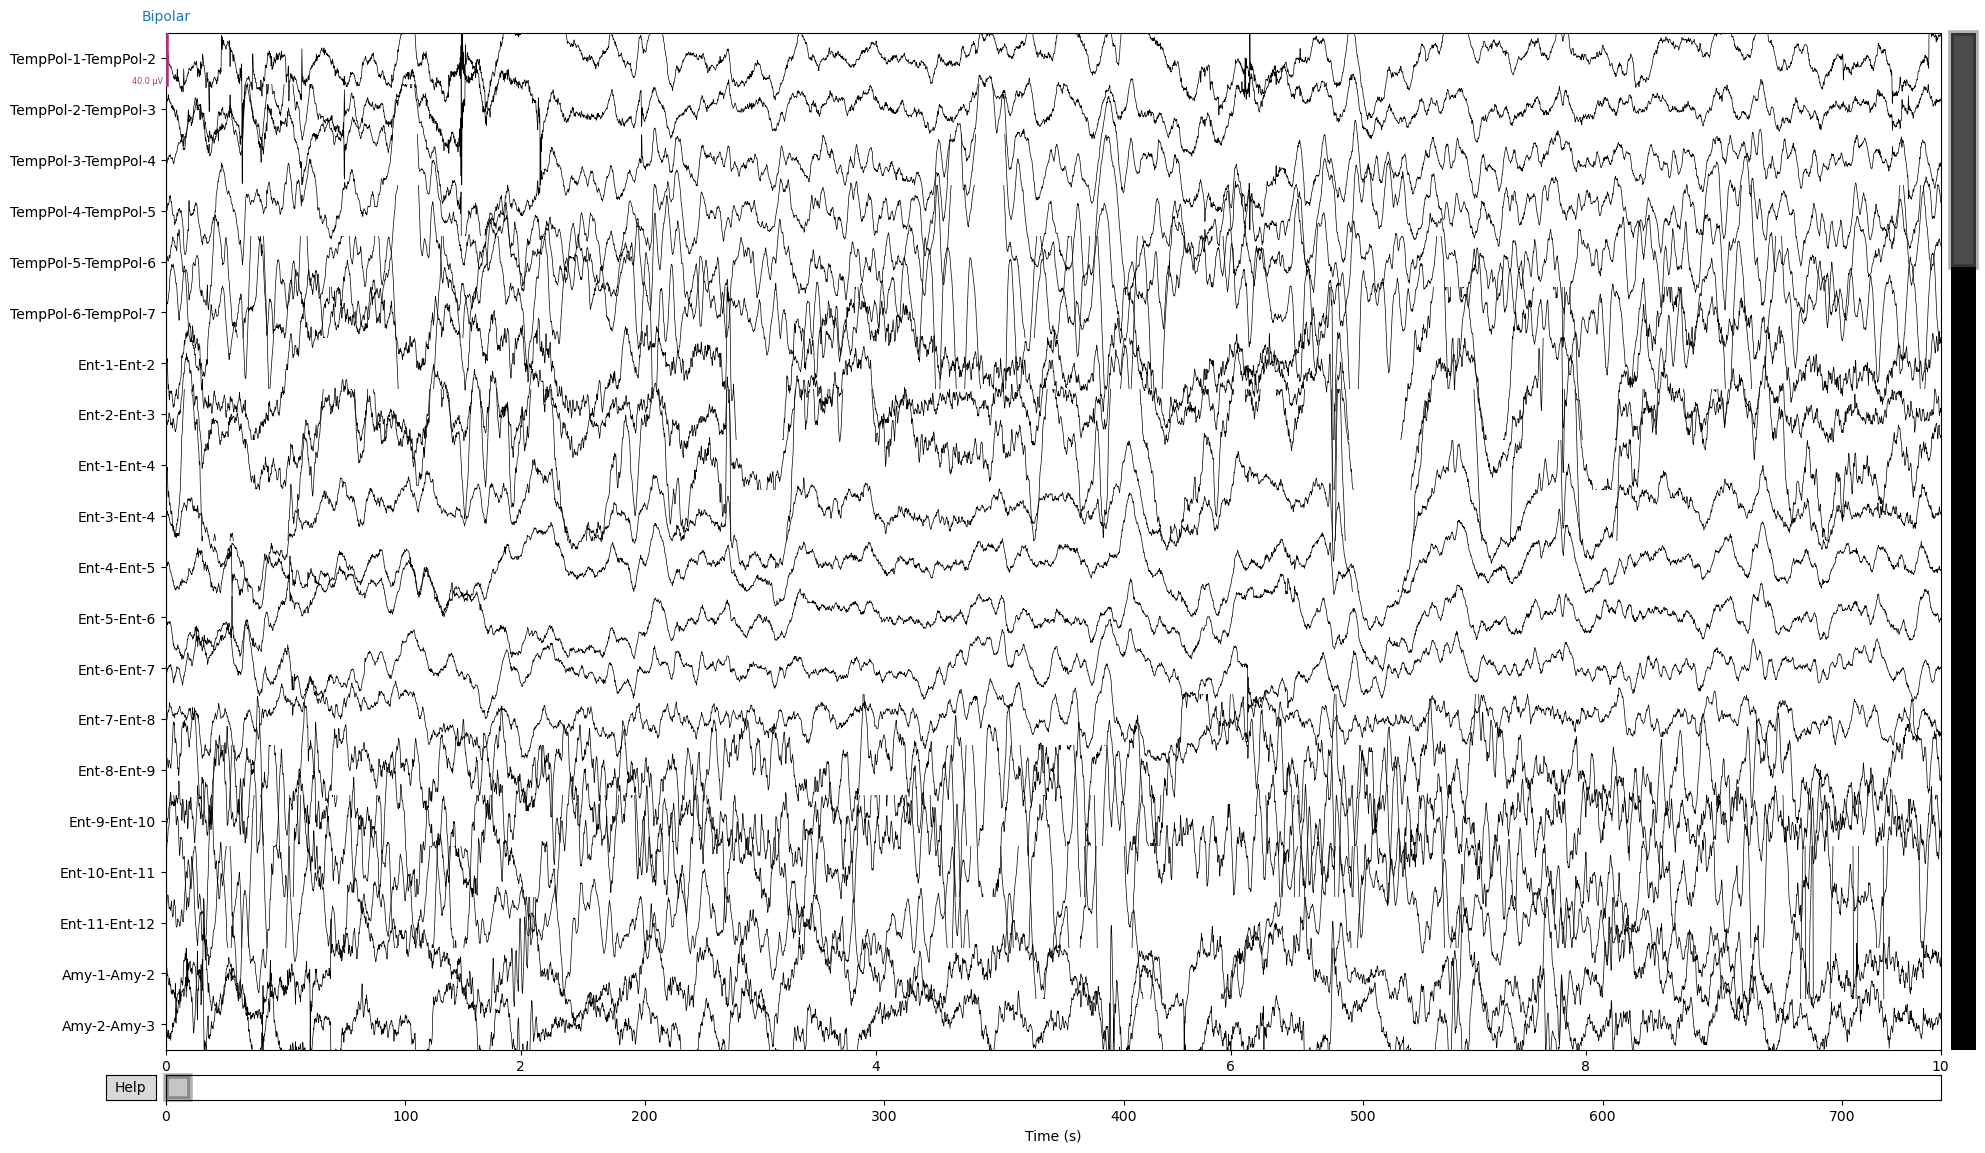

In [29]:
raw_bp.plot()